In [1]:
import json
import numpy as np
import random, math
import copy

def read_json(fname, key_int=False):
    with open(fname, 'r') as file:
        data = file.read()
        json_data = json.loads(data)
        
        if not key_int:
            return json_data
        
        json_data = {int(key): value for key, value in json_data.items()}
        return json_data
    
CHAR_INDICES = read_json('../models/CHAR_INDICES.json', key_int=False)

In [2]:
# text = "aku|makan"

# look_back = 10
# look_front = 5

# def create_dataset(text, look_back, look_front):
#     X, y = [], []
#     text = '|' + text
#     data = ['?'] * look_back
#     for i in range(1, len(text)):
#         current_char = text[i]
#         before_char = text[i-1]

#         if current_char == '|':
#             continue

#         data = data[1:look_back] + [current_char]  # X data
#         target = 1 if before_char == '|' else 0  # y data

#         # look front
#         j = 0
#         while len(data) < look_back + look_front:
#             if i+j+1 < len(text):
#                 if text[i+j+1] == '|':
#                     j += 1
#                     continue
#                 data.append(text[i+j+1])
#             else:
#                 data.append('?')

#             j += 1

#         X.append(data)
#         y.append(target)
#     y[-1] = 1  # end text is '|'
#     return X, y

# dataX, dataY = create_dataset(text, look_back, look_front)
# for i in range(len(dataX)):
#     print(dataX[i], dataY[i])

### PREPROCESSING

In [3]:
def replace(text, wordlist):
    for new_word, list_ in wordlist.items():
        for old_word in list_:
            text = text.replace(old_word.lower(), new_word)
    
    return text

def preprocessing(text, wordlist):
    text = text.lower()  # to lower-case
    text = replace(text, wordlist)

    # check if char is in CHAR_INDICES
    for char in text:
        if char not in CHAR_INDICES:
            text = text.replace(char, '')
            
    return text

def create_dataset(text, look_back, look_front):
    X, y = [], []
    text = '|' + text
    data = [CHAR_INDICES['<pad>']] * look_back
    for i in range(1, len(text)):
        current_char = text[i]
        before_char = text[i-1]

        if current_char == '|':
            continue

        data = data[1:look_back] + [CHAR_INDICES[current_char]]  # X data
        target = 1 if before_char == '|' else 0  # y data

        # look front
        j = 0
        while len(data) < look_back + look_front:
            if i+j+1 < len(text):
                if text[i+j+1] == '|':
                    j += 1
                    continue
                data.append(CHAR_INDICES[text[i+j+1]])
            else:
                data.append(CHAR_INDICES['<pad>'])

            j += 1

        X.append(data)
        y.append(target)
    y[-1] = 1  # end text is '|'
    return X, y


def encode_data(X, y):
    sequence_len = len(X[0])
    encode_X = np.zeros((len(X), sequence_len, len(CHAR_INDICES)), dtype=np.bool_)
    encode_y = np.zeros((len(y), 2), dtype=np.bool_)
    for i, (data, target) in enumerate(zip(X, y)):
        for t, char in enumerate(data):
            encode_X[i, t, char] = 1
        encode_y[i, target] = 1
        
    return encode_X, encode_y


def read_text(file):
    return open(file, encoding='utf-8', errors="ignore").read()

### TRAIN TEST

In [4]:
file_train = [
    "../dataset/id_meta_part_1_translate_80000.txt",
    "../dataset/id_meta_part_1_translate_50000.txt",
]

file_test = [
    "../dataset/id_meta_part_1_translate_20000.txt",
]

file_validate = [
    "../dataset/id_meta_part_1_translate_30000.txt",
]

In [5]:
wordlist = {
    '': ['\n'],
}

wordlist2 = copy.deepcopy(wordlist)
wordlist2[''].append('|')

nb_data_train = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_train)
nb_data_validate = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_validate)
nb_data_test = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_test)

print('Number of data on train set: ', nb_data_train)
print('Number of data on validate set: ', nb_data_validate)
print('Number of data on test set: ', nb_data_test)
print('Number of all data: ', sum([nb_data_train, nb_data_validate, nb_data_test]))

Number of data on train set:  4799194
Number of data on validate set:  2621281
Number of data on test set:  2806109
Number of all data:  10226584


### DATASET GENERATOR

In [6]:
def generator(files, wordlist, batch_size=1024, look_back=20, look_front=5, mode='Training', display_=False):
    while True:
        copy_files = files.copy()
        random.shuffle(copy_files)

        for file in copy_files:
            if display_ is True:
                print(f'\n{mode} file: ' + file)

            text = read_text(file)
            text = preprocessing(text, wordlist)
            X_data, X_support, y_data = create_dataset(text, look_back, look_front)
            X_data, y_data = encode_data(X_data, y_data)

            samples_per_epoch  = len(X_data)
            number_of_batches = int(math.ceil(samples_per_epoch / batch_size))

            for counter in range(number_of_batches):
                X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
                y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
                yield X_batch, y_batch

### MODEL

2024-06-18 14:53:53.558605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 14:53:54.162076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-18 14:53:54.903355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 14:53:54.923974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 14:53:54.924344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

Total params:  16110


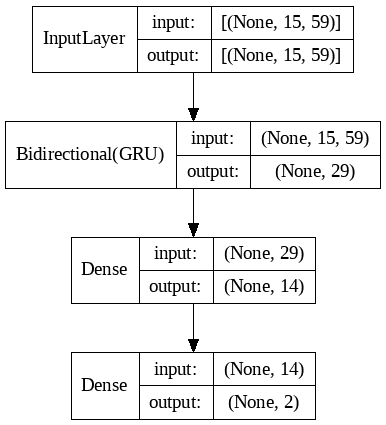

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Bidirectional, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import copy
tf.config.list_physical_devices('GPU')

tf.random.set_seed(42)

LOOK_BACK = 10
LOOK_FRONT = 5
batch_size = 1000
steps_per_epoch = int(nb_data_train / batch_size)
validation_steps = int(nb_data_train / (batch_size * 10))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

def define_model(input1):
    model = Sequential()
    model.add(Bidirectional(GRU(input1[1]//2, input_shape=input1, return_sequences=False), merge_mode='sum', weights=None, input_shape=input1))
    model.add(Dense(input1[1]//4, activation='linear'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  # compile

    print('Total params: ', model.count_params())
    return model

input_shape1 = (LOOK_BACK + LOOK_FRONT, len(CHAR_INDICES))

model = define_model(input_shape1)  # define model

# plot model
image_name = '../images/model.png'
plot_model(model, image_name, show_shapes=True, show_layer_names=False)
display(Image(filename=image_name))

In [8]:
# Generators
training_generator = generator(file_train, 
                               wordlist, 
                               batch_size, 
                               look_back=LOOK_BACK,
                               look_front=LOOK_FRONT, 
                               mode='Training')

validation_generator = generator(file_validate, 
                                 wordlist, 
                                 batch_size, 
                                 look_back=LOOK_BACK, 
                                 look_front=LOOK_FRONT, 
                                 mode='Validation')

print('steps per epoch', steps_per_epoch)
print('validation steps', validation_steps)

steps per epoch 4799
validation steps 479


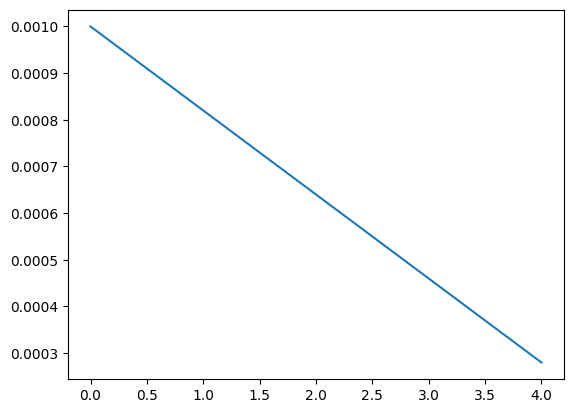

In [9]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from matplotlib import pyplot as plt

# checkpoint
filepath="../models/model-gru-{epoch:03d}-{accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

def step_decay(epoch):
    initial_lrate = 0.001
    min_lrat = 0.0001
    drop_per_epoch = (initial_lrate - min_lrat) / NB_EPOCH
    lrate = initial_lrate - (drop_per_epoch * epoch)
    return lrate

NB_EPOCH = 5
lrate = LearningRateScheduler(step_decay)

plt.plot([step_decay(i) for i in range(NB_EPOCH)]);
plt.savefig('../images/gru-step-decay.png')

In [10]:
callbacks_list = [checkpoint, lrate]

history = model.fit(training_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=NB_EPOCH,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/5


2024-06-18 14:54:08.516761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-18 14:54:08.715881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 14:54:08.717103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

  11/4799 [..............................] - ETA: 50s - loss: 0.5684 - accuracy: 0.7865   

2024-06-18 14:54:11.278613: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-06-18 14:54:11.282077: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-06-18 14:54:11.284041: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



4795/4799 [============================>.] - ETA: 0s - loss: 0.1852 - accuracy: 0.9270

2024-06-18 14:55:25.319951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-18 14:55:25.473002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 14:55:25.473931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: accuracy improved from -inf to 0.92698, saving model to ../models/model-gru-001-0.9270.keras
4799/4799 [==============================] - 80s 16ms/step - loss: 0.1852 - accuracy: 0.9270 - val_loss: 0.0947 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 2/5
4799/4799 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9736
Epoch 2: accuracy improved from 0.92698 to 0.97356, saving model to ../models/model-gru-002-0.9736.keras
4799/4799 [==============================] - 84s 18ms/step - loss: 0.0715 - accuracy: 0.9736 - val_loss: 0.0661 - val_accuracy: 0.9759 - lr: 8.2000e-04
Epoch 3/5
4799/4799 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9797
Epoch 3: accuracy improved from 0.97356 to 0.97974, saving model to ../models/model-gru-003-0.9797.keras
4799/4799 [==============================] - 80s 17ms/step - loss: 0.0563 - accuracy: 0.9797 - val_loss: 0.0597 - val_accuracy: 0.9785 - lr: 6.4000e-04
Epoch 4/5
4797/4799 [====================

In [11]:
# save history as csv
import pandas as pd
df = pd.DataFrame(history.history)
df.to_csv('../models/history-gru.csv', index=False)